# FPLMonkey Notebook

In [1]:
!pip install lxml
!pip install bs4
!pip install backoff

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from helpers import *
from pathlib import Path
from fastai.tabular.all import *
from matplotlib import style

In [3]:
path = Path('./')

In [4]:
train_df = pd.read_csv(path/'data/train_v7.csv', index_col=0, dtype={'season':str, 
                                                                     'squad':str,
                                                                     'comp':str})

In [5]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
0,Aaron Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 107552 entries, 0 to 107551
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   player                                      107552 non-null  object 
 1   gw                                          107552 non-null  int64  
 2   position                                    107552 non-null  int64  
 3   minutes                                     107552 non-null  int64  
 4   team                                        107552 non-null  object 
 5   opponent_team                               107552 non-null  object 
 6   relative_market_value_team                  39489 non-null   float64
 7   relative_market_value_opponent_team         39466 non-null   float64
 8   was_home                                    107552 non-null  bool   
 9   total_points                                107552 non-null  int64  
 

In [7]:
train_df[train_df['season']=='2021'].head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
90437,Aaron Connolly,1,4,45,Brighton and Hove Albion,Chelsea,0.466873,2.184688,True,1,...,0.3,0.0,1.0,0.0,2.0,2.0,100.0,9.0,3.0,3.0
90438,Aaron Cresswell,1,2,90,West Ham United,Newcastle United,0.682407,0.626058,True,1,...,0.0,0.0,0.0,0.0,47.0,63.0,74.6,47.0,0.0,0.0
90439,Aaron Mooy,1,3,0,Brighton and Hove Albion,Chelsea,0.466873,2.184688,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90440,Aaron Ramsdale,1,1,90,Sheffield United,Wolverhampton Wanderers,0.361923,0.788413,True,1,...,0.0,0.0,0.0,0.0,13.0,24.0,54.2,15.0,0.0,0.0
90441,Abdoulaye Doucouré,1,3,90,Everton,Tottenham Hotspur,1.152919,1.694101,False,3,...,0.0,0.2,4.0,0.0,48.0,56.0,85.7,40.0,1.0,1.0


In [8]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

In [9]:
# set validaton point/length and categorical/continuous variables
valid_season = '2021'
valid_gw = 25
valid_len = 1
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [10]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

In [11]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [12]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [13]:
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

In [14]:
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105642 entries, 0 to 105641
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   gw                                          105642 non-null  category
 1   minutes                                     105642 non-null  int64   
 2   minutes_last_1                              105642 non-null  float64 
 3   minutes_last_10                             105642 non-null  float64 
 4   minutes_last_2                              105642 non-null  float64 
 5   minutes_last_3                              105642 non-null  float64 
 6   minutes_last_4                              105642 non-null  float64 
 7   minutes_last_5                              105642 non-null  float64 
 8   minutes_last_all                            105642 non-null  int64   
 9   opponent_team                               105642 non-null

In [15]:
# need to remove 0 minute rows from the validation set
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                           ignore_index=True)

In [16]:
# and redo the valid indexes
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)

In [17]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(104900, 105202)

In [18]:
train_valid_df[cat_vars + ['player']].nunique()

gw                 38
season              5
position            4
team               30
opponent_team      30
was_home            2
player           1477
dtype: int64

In [19]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

In [20]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[FillMissing, Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

In [21]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [22]:
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,relative_market_value_team_season_na,relative_market_value_opponent_team_season_na,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points
0,14,1617,3,Hull City,Middlesbrough,False,Tom Huddlestone,False,False,2.900000e+01,0.494447,0.452793,1.0
1,14,1920,1,Sheffield United,Wolverhampton Wanderers,False,Dean Henderson,False,False,9.000000e+01,0.150631,0.673382,3.0
2,32,1718,2,Bournemouth,Watford,False,Tyrone Mings,False,False,9.085513e-07,0.379765,0.547242,0.0
3,24,1718,2,Southampton,Tottenham Hotspur,True,Wesley Hoedt,False,False,9.000000e+01,0.809578,1.751141,3.0
4,34,1617,4,Chelsea,Southampton,True,Diego Da Silva Costa,False,False,9.000000e+01,2.243698,0.796805,16.0
5,20,1718,3,Manchester City,Newcastle United,False,Fernando Luiz Rosa,False,False,9.000000e+01,2.016093,0.547176,3.0
6,22,1920,1,Brighton and Hove Albion,Everton,False,David Button,False,False,9.085513e-07,0.476156,1.125166,0.0
7,21,2021,3,Tottenham Hotspur,Brighton and Hove Albion,False,Heung-Min Son,True,True,9.000000e+01,0.704200,0.704200,2.0
8,9,1617,4,Sunderland,West Ham United,False,Fabio Borini,False,False,9.085513e-07,0.418392,0.895471,0.0
9,33,1819,3,Huddersfield Town,Leicester City,True,Danny Williams,False,False,9.085513e-07,0.273778,0.796050,0.0


In [23]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

In [24]:
# learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                         n_out=1, loss_func=F.mse_loss, metrics=rmse)

learn = tabular_learner(dls, y_range=y_range, layers=[500,250], loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

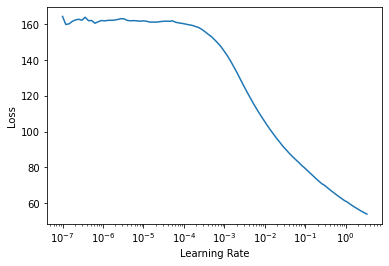

In [25]:
learn.lr_find()

In [26]:
# [500, 250]
learn.fit_one_cycle(2, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,3.742217,6.959497,2.638086,00:22
1,3.294800,6.300011,2.509982,00:22


In [27]:
# check that rmse matches the training output above
preds,targs = learn.get_preds()
r_mse(preds,targs)

2.509982

In [28]:
preds.size()

torch.Size([302, 1])

In [29]:
valid_gws = np.arange(valid_gw, valid_gw + valid_len, 1)
print(valid_gws)

[25]


In [30]:
preds_gw_df = train_valid_df[['player'] + cat_vars + cont_vars + dep_var].copy()
preds_gw_df = preds_gw_df[preds_gw_df['gw'] == valid_gw]
preds_gw_df = preds_gw_df[preds_gw_df['season'] == valid_season]
preds_gw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 104900 to 105201
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   player                                      302 non-null    object  
 1   gw                                          302 non-null    category
 2   season                                      302 non-null    category
 3   position                                    302 non-null    int64   
 4   team                                        302 non-null    object  
 5   opponent_team                               302 non-null    object  
 6   was_home                                    302 non-null    bool    
 7   minutes                                     302 non-null    int64   
 8   relative_market_value_team_season           0 non-null      float64 
 9   relative_market_value_opponent_team_season  0 non-null      float64 

In [31]:
preds_gw_df['predicted_points'] = preds.data.cpu().numpy()
preds_gw_df

,player,gw,season,position,team,opponent_team,was_home,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points,predicted_points
104900,Aaron Cresswell,25,2021,2,West Ham United,Tottenham Hotspur,True,90,NaN,NaN,2.0,3.248787
104901,Aaron Ramsdale,25,2021,1,Sheffield United,Fulham,False,90,NaN,NaN,3.0,3.778891
104902,Aaron Wan-Bissaka,25,2021,2,Manchester United,Newcastle United,True,90,NaN,NaN,2.0,4.230538
104903,Abdoulaye Doucouré,25,2021,3,Everton,Liverpool,False,90,NaN,NaN,3.0,3.152510
104904,Adama Traoré,25,2021,3,Wolverhampton Wanderers,Leeds,True,90,NaN,NaN,6.0,3.837979
...,...,...,...,...,...,...,...,...,...,...,...,...
105197,Willian José Da Silva,25,2021,4,Wolverhampton Wanderers,Leeds,True,86,NaN,NaN,2.0,4.209795
105198,Xherdan Shaqiri,25,2021,3,Liverpool,Everton,True,27,NaN,NaN,1.0,2.175727
105199,Youri Tielemans,25,2021,3,Leicester City,Aston Villa,False,87,NaN,NaN,2.0,3.732248
105200,Yves Bissouma,25,2021,3,Brighton and Hove Albion,Crystal Palace,True,90,NaN,NaN,2.0,2.852076


In [32]:
# get the precited points of a single player in a gw
player_prediction = preds_gw_df[preds_gw_df['player'] == 'Harry Kane'].predicted_points
player_prediction.iloc[0]

5.9053617

In [33]:
# ordered by precited points
preds_gw_df.sort_values(by='predicted_points', ascending=False).head()

,player,gw,season,position,team,opponent_team,was_home,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points,predicted_points
105107,Mohamed Salah,25,2021,3,Liverpool,Everton,True,90,NaN,NaN,2.0,6.720428
105168,Sadio Mané,25,2021,3,Liverpool,Everton,True,90,NaN,NaN,1.0,6.246008
104937,Bruno Miguel Borges Fernandes,25,2021,3,Manchester United,Newcastle United,True,90,NaN,NaN,12.0,6.116500
105001,Harry Kane,25,2021,4,Tottenham Hotspur,West Ham United,False,90,NaN,NaN,2.0,5.905362
105148,Raheem Sterling,25,2021,3,Manchester City,Arsenal,False,90,NaN,NaN,8.0,5.583663


In [34]:
preds_gw_df.to_csv('data/predictions_for_season_' + str(valid_season) + '_gw_' + str(valid_gw) + '.csv')